<a href="https://colab.research.google.com/github/Starliyiyu/STA303-Final-Project/blob/main/Copy_of_STA414_2104_2023_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA414 A1

## *2023/02/03*

### *author: Yiyu Li, collaborators: Xiaoyu Ma, Siyi Li*




# Q1 - Decision Theory

One successful use of probabilistic models is for building spam filters, which take in an email and take different actions depending on the likelihood that it’s spam.

Imagine you are running an email service. You have a well-calibrated spam classifier that tells you the probability that a particular email is spam: $p(spam|email)$. You have four options for what to do with each email: You can list it as important email, show it to the user, put it in the spam folder, or delete it entirely.

Depending on whether or not the email really is spam, the user will suffer a different amount  of wasted time for the different actions we can take, $L$(action, spam):

Action   | Spam        | Not spam
-------- | ----------- | -----------
Important| 15         | 0
Show     | 5          | 1
Folder   | 1           | 40
Delete   | 0           | 150

## Q1.1
[3pts] Plot the expected wasted user time for each of the three possible actions, as a function of the probability of spam: $p(spam|email)$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

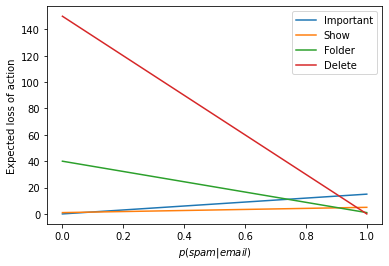

In [ ]:
losses = [[15, 0],[5, 1], [1, 40],[0, 150]]
actions_names = ['Important','Show', 'Folder', 'Delete']
num_actions = len(losses)
def expected_loss_of_action(prob_spam, action):
    #TODO: Return expected loss over a Bernoulli random variable
    # with mean prob_spam.
    # Losses are given by the table above.
    return losses[action][0]*prob_spam + losses[action][1]*(1-prob_spam)
    
    
prob_range = np.linspace(0., 1., num=600) 

# Make plot
for action in range(num_actions):
    plt.plot(prob_range, expected_loss_of_action(prob_range, action), label=actions_names[action])

plt.xlabel('$p(spam|email)$')
plt.ylabel('Expected loss of action')
plt.legend()


## Q1.2
[2pts] Write a function that computes the optimal action given the probability of spam.

In [ ]:
def optimal_action(prob_spam):
    #TODO: return best action given the probability of spam. 
    #Hint: np.argmin might be helpful.
    all_e_loss = []
    for action in range(num_actions):
      all_e_loss.append(expected_loss_of_action(prob_spam, action))
    all_e_loss = np.array(all_e_loss)
    return actions_names[np.argmin(all_e_loss)]

    

## Q1.3
[4pts] Plot the expected loss of the optimal action as a function of the probability of spam.


Color the line according to the optimal action for that probability of spam.


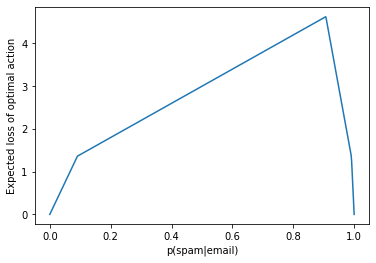

In [ ]:
prob_range = np.linspace(0., 1., num=600) 
optimal_losses = []
optimal_actions = []
for p in prob_range:
    # TODO: Compute the optimal action and its expected loss for
    # probability of spam given by p.
    optimal_actions.append(optimal_action(p))
    optimal_losses.append(expected_loss_of_action(p, actions_names.index(optimal_action(p))))

plt.xlabel('p(spam|email)')
plt.ylabel('Expected loss of optimal action')
plt.plot(prob_range, optimal_losses)

## Q1.4
[4pts] For exactly which range of the probabilities of an email being spam should we delete an email?

Find the exact answer by hand using algebra.



Your answer:

We know that within this range, the expected loss of deletion is smallest among all expected losses, thus, the cutoff of this range according to the Q 1.1 plot is:

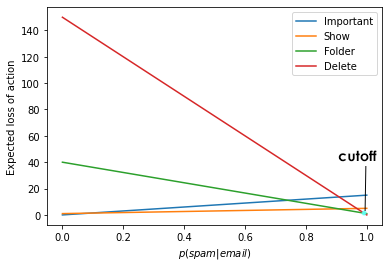



where $\mathrm{E}[Delete] = \mathrm{E}[Folder]$.

Let $p$ denote the probalility cutoff. We have:

$$\mathrm{E}[Delete] = 0 * p + 150 * (1-p) =  150 - 150p$$
$$\mathrm{E}[Folder] = 1 * p + 40 * (1-p) =  40 - 39p$$

Then

$$\mathrm{E}[Delete] = \mathrm{E}[Folder]$$

$$\implies 150 - 150p = 40 - 39p$$

$$\implies p ≈ 0.991$$

Thus, we can conclude that, we should delete the email when the probabilities of the email being spam is approximately within the range of $[0.991, 1]$.





# Q2 - Naïve Bayes, A Generative Model

![](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true)


In this question, we'll fit a Naïve Bayes model to the fashion MNIST dataset, and use this model for making predictions and generating new images from the same distribution. MNIST is a dataset of 28x28 black-and-white images of items of clothing. We represent each image by a vector $x^{(i)} \in \{0,1\}^{784}$, where 0 and 1 represent white and black pixels respectively. Each class label $c^{(i)}$ is a different item of clothing, which in the code is represented by a 10-dimensional one-hot vector.

The Naïve Bayes model parameterized by $\theta$ and $\pi$ defines the following joint probability of $x$ and $c$,
$$p(x,c|\theta,\pi) = p(c|\pi)p(x|c,\theta) = p(c|\pi)\prod_{j=1}^{784}p(x_j|c,\theta),$$
where $x_j | c,\theta \sim \operatorname{Bernoulli}(\theta_{jc})$ or in other words $p(x_j | c,\theta) = \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}$, and $c|\pi$ follows a simple categorical distribution, i.e. $p(c|\pi) = \pi_c$.

We begin by learning the parameters $\theta$ and $\pi$. The following code will download and prepare the training and test sets.

In [ ]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')
    # Remove the data point that cause log(0)
    remove = (14926, 20348, 36487, 45128, 50945, 51163, 55023)
    train_images = np.delete(train_images,remove, axis=0)
    train_labels = np.delete(train_labels, remove, axis=0)
    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_fashion_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels =  fashion_mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

## Q2.1
[2pts] Derive the expression for the Maximum Likelihood Estimator (MLE) of $\theta$ and $\pi$.

Your answer:

Let $N$ be the training sample size. Then:

\begin{align*}
        l(θ, π) &= Log(L(θ, π)) \\
        &= Log(∏^{N}_{i=1} p(x^{(i)},c^{(i)}|\theta,\pi)) \\
        &= Log(∏^{N}_{i=1} \biggr [ p(c^{(i)}|\pi)\prod_{j=1}^{784}p(x_j^{(i)}|c^{(i)},\theta)\biggr ]) \\ 
        &= ∑^{N}_{i=1}\biggr [Log( p(c^{(i)}|\pi)\prod_{j=1}^{784}p(x_j^{(i)}|c^{(i)},\theta))\biggr ] \\
         &= ∑^{N}_{i=1}\biggr [Log( p(c^{(i)}|\pi)) + Log(\prod_{j=1}^{784}p(x_j^{(i)}|c^{(i)},\theta))\biggr ] \\
         &= ∑^{N}_{i=1}\biggr [Log( p(c^{(i)}|\pi)) + ∑_{j=1}^{784}Log(p(x_j^{(i)}|c^{(i)},\theta))\biggr ] \\
         &= ∑^{N}_{i=1}Log( p(c^{(i)}|\pi)) + ∑^{N}_{i=1}∑_{j=1}^{784}Log(p(x_j^{(i)}|c^{(i)},\theta)) \\
         &= ∑^{N}_{i=1}Log( p(c^{(i)}|\pi)) + ∑^{N}_{i=1}∑_{j=1}^{784}Log(\theta_{jc^{(i)}}^{x_j^{(i)}}(1-\theta_{jc^{(i)}})^{1-x_j^{(i)}}) \\
         &\text{ (note: $\mathbb{1}(c^{(i)} = c)$ is omitted for now for simplification)} \\
         \\
         &= ∑^{N}_{i=1}Log( p(c^{(i)}|\pi)) + ∑^{N}_{i=1}∑_{j=1}^{784}\biggr [Log\theta_{jc^{(i)}}^{x^{(i)}_j} + (1-x_j^{(i)})Log(1-\theta_{jc^{(i)}})\biggr ] \\
         &= ∑^{N}_{i=1}∑_{c}\mathbb{1}(c^{(i)} = c)Log(\pi_c) + ∑^{N}_{i=1}∑_{j=1}^{784}\biggr [Log\theta_{jc^{(i)}}^{x^{(i)}_j} + (1-x_j^{(i)})Log(1-\theta_{jc^{(i)}})\biggr]
\end{align*}

since $∑_{c}\pi_c = 1$, we have:

\begin{align*}
&= ∑^{N}_{i=1}∑_{c}\biggr [\mathbb{1}(c^{(i)} = c)Log(\pi_c) + 1 - 1 \biggr ]\\
&= ∑^{N}_{i=1}∑_{c}\biggr [\mathbb{1}(c^{(i)} = c)Log(\pi_c) + 1 - ∑_{c}\pi_c\biggr ] \\
\implies \frac{\partial l}{\partial \pi_c} &= ∑^{N}_{i=1}∑_{c} \frac{\partial}{\partial \pi_c}\biggr [\mathbb{1}(c^{(i)} = c)Log(\pi_c) + 1 - ∑_{c}\pi_c\biggr ] \\
&= ∑^{N}_{i=1} \biggr [\frac{\mathbb{1}(c^{(i)} = c)}{\pi_c} - 1 \biggr ] (\text{since $∑_{c}$ adds constant times})
\end{align*}

Then

\begin{align*}
\frac{\partial l}{\partial \pi_c} &= 0 \\
\implies ∑^{N}_{i=1} \biggr [\frac{\mathbb{1}(c^{(i)} = c)}{\pi_c} - 1 \biggr ] &= 0 \\
\implies ∑^{N}_{i=1} \frac{\mathbb{1}(c^{(i)} = c)}{\pi_c} &= ∑^{N}_{i=1} 1 \\
\implies \frac{1}{\pi_c}∑^{N}_{i=1}\mathbb{1}(c^{(i)} = c)  &= N \\
\\
\implies \hat\pi_c  =  \frac{∑^{N}_{i=1}\mathbb{1}(c^{(i)} = c)}{N}\\
\end{align*}

As for $\theta:$

\begin{align*}
\frac{\partial l}{\partial \theta_{jc}} &= ∑^{N}_{i=1}∑_{j=1}^{784} \frac{\partial }{\partial \theta_{jc}}\biggr [ Log\theta_{jc^{(i)}}^{x^{(i)}_j} + (1-x_j^{(i)})Log(1-\theta_{jc^{(i)}}) \biggr ]\\
 &= ∑^{N}_{i=1}∑_{j=1}^{784} \biggr [\frac{x_j^{(i)}}{\theta_{jc^{(i)}}} -\frac{1-x_j^{(i)}}{1-\theta_{jc^{(i)}}} \biggr ]\\
 &= ∑^{N}_{i=1}∑_{j=1}^{784} \biggr [\frac{x_j^{(i)} - x_j^{(i)}\theta_{jc^{(i)}}- \theta_{jc^{(i)}} + x_j^{(i)}\theta_{jc^{(i)}}}{\theta_{jc^{(i)}}(1-\theta_{jc^{(i)}})} \biggr ]\\
 &= ∑^{N}_{i=1}∑_{j=1}^{784} \biggr [\frac{x_j^{(i)}- \theta_{jc^{(i)}}}{\theta_{jc^{(i)}}(1-\theta_{jc^{(i)}})} \biggr ]\\
  &=  \frac{∑^{N}_{i=1}\biggr [x_j^{(i)}- \theta_{jc}\biggr ]}{∑^{N}_{i=1}\biggr [\theta_{jc}(1-\theta_{jc})\biggr ]} * \mathbb{1}(c^{(i)} = c)\\
\end{align*}

Then

\begin{align*}
\frac{\partial l}{\partial \theta_{jc}} &= 0 \\
\implies \frac{∑^{N}_{i=1}\biggr [x_j^{(i)}- \theta_{jc}\biggr ]}{∑^{N}_{i=1}\biggr [\theta_{j}(1-\theta_{jc})\biggr ]} * \mathbb{1}(c^{(i)} = c) &= 0 \\
\implies ∑^{N}_{i=1}\biggr [ x_j^{(i)}\mathbb{1}(c^{(i)} = c)\biggr ] &= ∑^{N}_{i=1}\biggr [ \theta_{jc}\mathbb{1}(c^{(i)} = c)\biggr ] \\
\\
\implies \hat\theta_{jc}  =  \frac{∑^{N}_{i=1} \biggr [x_j^{(i)}\mathbb{1}(c^{(i)} = c)\biggr ]}{∑^{N}_{i=1}\mathbb{1}(c^{(i)} = c)}\\
\end{align*}

## Q2.2
[4pts] Using the MLE for this data, many entries of $\theta$ will be estimated to be 0, which seems extreme. So we look for another estimation method.

Assume the prior distribution of $\theta$ is such that the entries are i.i.d. and drawn from $\operatorname{Beta}(2,2)$. Derive the Maximum A Posteriori (MAP) estimator for $\theta$ (it has a simple final form). You can return the MLE for $\pi$ in your implementation. From now on, we will work with this estimator.

Your answer:

By the Beta pdf,

$$p(\theta) = 6 \theta (1-\theta)$$

To find MAP:

\begin{align*}
        Log(∏^{N}_{i=1} p(x^{(i)},c^{(i)}|\theta,\pi)*p(\theta)) 
        &= Log(∏^{N}_{i=1} p(x^{(i)},c^{(i)}|\theta)*p(\theta)) \text{  (since $\pi$ is irrelevant)}\\
        &= Log(∏^{N}_{i=1} p(x^{(i)},c^{(i)}|\theta))+Log(p(\theta))
\end{align*}

Then
\begin{align*}
Log(p(\theta)) &=Log(∏^{}_{c}∏^{784}_{j=1} 6 \theta_{jc} (1-\theta_{jc})) \\
        &= ∑^{}_{c}∑^{784}_{j=1}Log( 6 \theta_{jc} (1-\theta_{jc}))
\end{align*}

Thus

\begin{align*}
\frac{\partial}{\partial \theta}\biggr [Log(∏^{N}_{i=1} p(x^{(i)},c^{(i)}|\theta))+Log(p(\theta))\biggr ] &=∑^{N}_{i=1}\frac{\mathbb{1}(c^{(i)} = c)(x_j^{(i)}- \theta_{jc})}{\theta_{jc}(1-\theta_{jc})} +  \frac{1- 2\theta_{jc}}{(1-\theta_{jc})\theta_{jc}}\\
&\text{(from Q}2.1) \\
\\
&=\frac{1}{\theta_{jc}(1-\theta_{jc})}∑^{N}_{i=1}\mathbb{1}(c^{(i)} = c)(x_j^{(i)}- \theta_{jc}) +  \frac{1- 2\theta_{jc}}{(1-\theta_{jc})\theta_{jc}} \\
\\
&= 0 \\
\\
\implies \frac{1}{\theta_{jc}(1-\theta_{jc})}∑^{N}_{i=1}\mathbb{1}(c^{(i)} = c)(x_j^{(i)}- \theta_{jc}) &=  \frac{2\theta_{jc}-1}{(1-\theta_{jc})\theta_{jc}} \\
\\
\implies ∑^{N}_{i=1}\mathbb{1}(c^{(i)} = c)(x_j^{(i)}- \theta_{jc}) &=  2\theta_{jc}-1 \\
\implies  1+∑^{N}_{i=1}\mathbb{1}(c^{(i)} = c)x_j^{(i)} &=  \biggr [2 + ∑^{N}_{i=1}\mathbb{1}(c^{(i)} = c)\biggr ]\theta_{jc} \\
\\
\implies \hat\theta_{jc} &=  \frac{1+∑^{N}_{i=1}\mathbb{1}(c^{(i)} = c)x_j^{(i)}}{2 + ∑^{N}_{i=1}\mathbb{1}(c^{(i)} = c)}
\end{align*}






In [ ]:
def train_map_estimator(train_images, train_labels):
    """ Inputs: train_images (N_samples x N_features), train_labels (N_samples x N_classes)
        Returns the MAP estimator theta_est (N_features x N_classes) and the MLE
        estimator pi_est (N_classes)"""
    
    big_n = np.size(train_labels, 0) # N
    indicator_sum = np.sum(train_labels, 0)
    
    pi_est = indicator_sum / big_n
    
    theta_est = (1 + np.matmul(train_images.T, train_labels)) / (2 + indicator_sum)

    return theta_est, pi_est
    



## Q2.3
[5pts] Derive an expression for the class log-likelihood $\log p(c|x,\theta,\pi)$ for a single image. Then, complete the implementation of the following functions. Recall that our prediction rule is to choose the class that maximizes the above log-likelihood, and accuracy is defined as the fraction of samples that are correctly predicted.

Report the average log-likelihood $\frac{1}{N}\sum_{i=1}^{N}\log p(c^{(i)}|x^{(i)},\hat{\theta},\hat{\pi})$ (where $N$ is the number of samples) on the training test, as well the training and test errors.

Your answer:

\begin{align*}
p(c|x,\theta,\pi) &= \frac{p(x, c|\theta,\pi)}{p(x|\theta,\pi)} \\
&= \frac{p(x, c|\theta,\pi)}{\sum_{c} p(x, c|\theta,\pi)} \\
&= \frac{p(c|\pi)p(x|c,\theta)}{\sum_cp(c|\pi)p(x|c,\theta)} \\
\\
\implies Log\biggr [ p(c|x,\theta,\pi) \biggr ] &= Log\biggr [ \frac{p(c|\pi)p(x|c,\theta)}{\sum_{c}p(c|\pi)p(x|c,\theta)} \biggr ] \\
&= Log\biggr [ p(c|\pi)p(x|c,\theta) \biggr ] - Log\biggr [\sum_{c}p(c|\pi)p(x|c,\theta)\biggr ]\\
&= Log\pi_c+\sum_{j=1}^{784}\biggr [x_jlog\theta_{jc}+(1-x_j)Log(1-\theta_{jc})\biggr ] - Log\biggr [\sum_{c}p(c|\pi)p(x|c,\theta)\biggr ]\\
\end{align*}



In [ ]:
def log_likelihood(images, theta, pi):
    """ Inputs: images (N_samples x N_features), theta, pi
        Returns the matrix 'log_like' of loglikehoods over the input images where
        log_like[i,c] = log p (c |x^(i), theta, pi) using the estimators theta and pi.
        log_like is a matrix of (N_samples x N_classes)
    Note that log likelihood is not only for c^(i), it is for all possible c's."""

    pxct = np.matmul(images, np.log(theta)) + np.matmul((1 - images), np.log(1-theta)) # second term in formula above
    log_like = np.log(pi) + pxct - np.log(np.matmul(np.exp(pxct), pi)).reshape(-1, 1) # combine together = log(p(c|x, theta, pi))

    return log_like

def accuracy(log_like, labels):
    """ Inputs: matrix of log likelihoods and 1-of-K labels (N_samples x N_classes)
    Returns the accuracy based on predictions from log likelihood values"""

    return np.mean(np.argmax(labels, 1) == np.argmax(log_like, 1))


N_data, train_images, train_labels, test_images, test_labels = load_fashion_mnist()
theta_est, pi_est = train_map_estimator(train_images, train_labels)

loglike_train = log_likelihood(train_images, theta_est, pi_est)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = log_likelihood(test_images, theta_est, pi_est)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MAP is {avg_loglike:.3f}")
print(f"Training accuracy for MAP is {train_accuracy:.3f}")
print(f"Test accuracy for MAP is {test_accuracy:.3f}")

Average log-likelihood for MAP is -34.231
Training accuracy for MAP is 0.651
Test accuracy for MAP is 0.638


## Q2.4
[2pts] Given this model's assumptions, is it always true that any two pixels $x_i$ and $x_j$ with $i \neq j$ are indenepdent given $c$? How about after marginalizing over $c$? Explain your answer.

Your answer:

(Part 1) Since Naïve Bayes assumes conditional independence between all independent variable features, we can conclude that any two pixels $x_i$ and $x_j$ with $i \neq j$ are indenepdent given $c$.

(Part 2) After marginalization:

\begin{align*}
p(x_i, x_j) &= \sum_c p(x_i,x_j,c)\\
&= \sum_c p(x_i, x_j|c)p(c)\\
&= \sum_cp(x_i|c)p(x_j|c)p(c) \text{ (by Part 1)}\\
&\neq \sum_c p(x_i|c)p(c) \sum_c p(x_j|c)p(c) \\
&= \sum_c p(x_i,c) \sum_c p(x_j,c)\\
&= p(x_i)p(x_j) \\
\\
\implies &\text{After marginalization, $x_i$ and $x_j$ with $i \neq j$ are not indenepdent given $c$.}
\end{align*}


## Q2.5 
[4pts] Since we have a generative model for our data, we can do more than just prediction. Randomly sample and plot 10 images from the learned distribution using the MAP estimates. (Hint: You first need to sample the class $c$, and then sample pixels conditioned on $c$.)

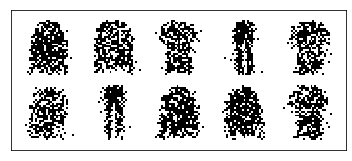

In [ ]:
def image_sampler(theta, pi, num_images):
    """ Inputs: parameters theta and pi, and number of images to sample
    Returns the sampled images (N_images x N_features)"""

    sampled_images = np.empty([num_images, np.size(theta, 0)]) #initialize return array
    for i in range(num_images):
      sampled_class = np.random.choice(np.size(pi, 0), p = pi)
      sampled_images[i, :] = np.random.binomial(1, theta[:, sampled_class]) # ber(p = estimated theta given c)
    
    return sampled_images




def plot_images(images, ims_per_row=5, padding=5, image_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((image_dimensions[0] + padding) * N_rows + padding,
                             (image_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], image_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + image_dimensions[0]) * row_ix
        col_start = padding + (padding + image_dimensions[1]) * col_ix
        concat_images[row_start: row_start + image_dimensions[0],
                      col_start: col_start + image_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    plt.plot()


sampled_images = image_sampler(theta_est, pi_est, 10)
plot_images(sampled_images)

## Q2.6
[4pts] One of the advantages of generative models is that they can handle missing data, or be used to answer different sorts of questions about the model. Assume we have only observed some pixels of the image. Let $x_E = \{x_p : \text{pixel $p$ is observed}\}$. Derive an expression for $p(x_j|x_E,\theta,\pi)$, the conditional probability of an unobserved pixel $j$ given the observed pixels and distribution parameters. (Hint: You have to marginalize over $c$.)

Your answer:



\begin{align*}
p(x_j|x_E,\theta,\pi)&= {p(x_j,x_E|\theta,\pi)\over p(x_E|\theta,\pi)}\\
&={\sum_cp(x_j,x_E,c|\theta,\pi)\over \sum_c p(x_E,c|\theta,\pi)} \text{ (marginalize over $c$)}\\
&={\sum_c p(c|\pi)p(x_j,x_E|\theta,c)\over \sum_c p(c|\pi)p(x_E|\theta,c)}\\ 
&={\sum_c p(c|\pi)p(x_j|\theta,c)p(x_E|\theta,c)\over \sum_c p(c|\pi)p(x_E|\theta,c)} \text{ (by i.i.d assumption)}
\end{align*}

## Q2.7
[4pts] We assume that only 30% of the pixels are observed. For the first 20 images in the training set, plot the images when the unobserved pixels are left as white, as well as the same images when the unobserved pixels are filled with the marginal probability of the pixel being 1 given the observed pixels, i.e. the value of the unobserved pixel $j$ is $p(x_j = 1|x_E,\theta,\pi)$.

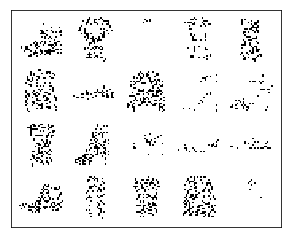

In [ ]:
def probabilistic_imputer(theta, pi, original_images, is_observed):
    """Inputs: parameters theta and pi, original_images (N_images x N_features), 
        and is_observed which has the same shape as original_images, with a value
        1. in every observed entry and 0. in every unobserved entry.
    Returns the new images where unobserved pixels are replaced by their 
    conditional probability"""
    
    for i in range(np.size(original_images, 0)):
      xe = original_images[i][is_observed[i] == 1] # xe = the obsesrved pixels in the ith image
      theta_image = theta[is_observed[i] == 1] # theta for observed pixels

      # find p(xe) by taking log first to avoid computation error
      log_pxe = np.matmul(np.log(theta_image.T), xe) + np.matmul(np.log(1 - theta_image.T), 1 - xe) # log(p(xe)|c, theta) = xlog(theta) + (1-x)log(1-theta) 
      pxe = np.exp(log_pxe) # take exp to get p(xe)

      # note that p(x_j = 1|xe, theta, pi) = theta_j, thus we replace this part by theta_j in the formula derived in 2.6
      theta_j = theta[is_observed[i] == 0]

      #p(x_j|xe, theta, pi) = final formula derived in 2.6 with p(x_j = 1|xe, theta, pi) = theta_j
      pxj = np.sum(theta_j * pi * pxe.reshape(1, -1), axis = 1) / (np.sum(pi * pxe)) 
      imputed_images = original_images.copy()
      imputed_images[i, is_observed[i] == 0] = pxj # fill the unobserved pixels in the ith image with the computed marginal probability

    return imputed_images
    
num_features = train_images.shape[1]
is_observed = np.random.binomial(1, p=0.3, size=(20, num_features))
plot_images(train_images[:20] * is_observed)

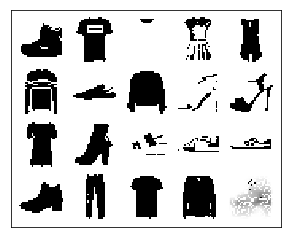

In [ ]:
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images[:20], is_observed)
plot_images(imputed_images)